In [1]:
from collections import defaultdict

from liblet import __version__, ANTLR, Tree, Stack, AnnotatedTreeWalker, iter2table, warn

__version__

'0.12.4-alpha'

In [2]:
# il punto di questa cella è importare simpleBlock2ast

from contextlib import redirect_stdout

import nbimporter
nbimporter.options['only_defs'] = False

with redirect_stdout(None):
    from L22 import SimpleBlockLang, simpleBlock2ast

# Control Flow Graph

## Sequenza

In [18]:
source = """
OUTPUT = 1 + 2 + 3;
"""

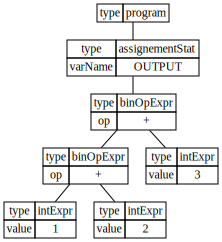

In [19]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

In [20]:
thread = AnnotatedTreeWalker('type')
LAST = None
THREADS = None

@thread.catchall
def catchall(visit, ast):

    global LAST

    for child in ast.children: visit(child)
    THREADS[LAST]['next'] = ast
    LAST = ast
    
def do_thread(ast):
    
    global LAST, THREADS

    THREADS = defaultdict(dict)
    START = Tree({'type': '<START>'})
    LAST = START
    thread(ast)
    THREADS[LAST]['next'] = None

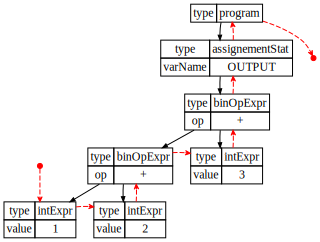

In [21]:
do_thread(ast)
ast.with_threads(THREADS)

### E i block?

In [7]:
source = """
{ OUTPUT = 1; OUTPUT = 2; }
{ OUTPUT = 3; OUTPUT = 4; }
"""

In [8]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))

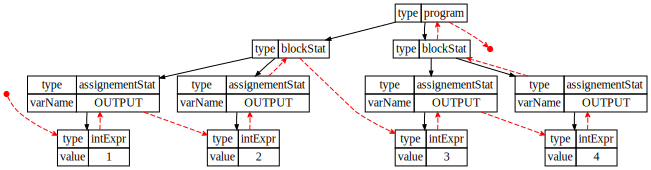

In [9]:
do_thread(ast)
ast.with_threads(THREADS)

In [40]:
@thread.register
def blockStat(visit, ast):
    
    global LAST
    
    for child in ast.children: visit(child)

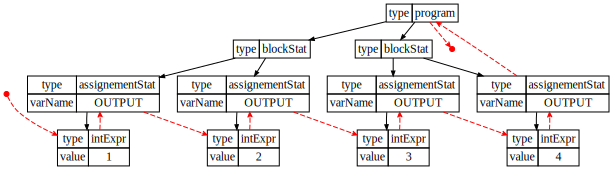

In [11]:
do_thread(ast)
ast.with_threads(THREADS)

## Selezione

In [22]:
source = """
var cond = INPUT0;

if cond == 0 then 
    OUTPUT = 1;
else
    OUTPUT = 2;
"""

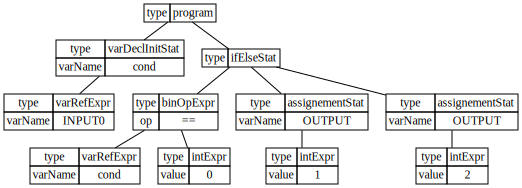

In [23]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

In [24]:
@thread.register
def ifElseStat(visit, ast):
    
    global LAST

    expr, true, false = ast.children

    join = Tree({'type': '<JOIN>'})
    temp = Tree('temp')

    visit(expr)
    THREADS[LAST]['next'] = ast
    #LAST = ast

    LAST = temp
    visit(true)
    THREADS[ast]['true'] = THREADS[temp]['next']
    THREADS[LAST]['next'] = join

    LAST = temp
    visit(false)
    THREADS[ast]['false'] = THREADS[temp]['next']
    THREADS[LAST]['next'] = join

    del THREADS[temp]

    LAST = join

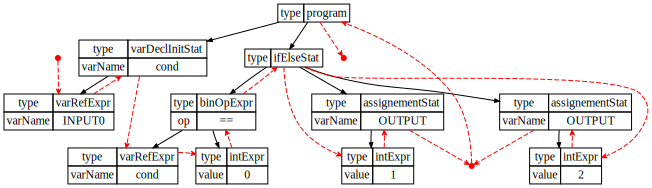

In [25]:
do_thread(ast)
ast.with_threads(THREADS)

## Iterazione

In [26]:
source = """
var n = INPUT0;
repeat 1 + n times 
    OUTPUT = 1;
OUTPUT = 2;
"""

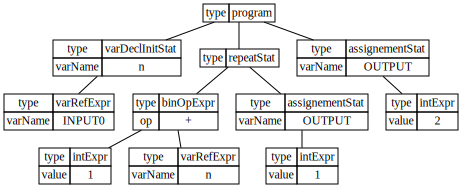

In [27]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

In [28]:
@thread.register
def repeatStat(visit, ast):
    
    global LAST

    count, stat = ast.children

    visit(count)
    THREADS[LAST]['next'] = ast
    LAST = ast

    visit(stat)
    THREADS[ast]['repeat'] = THREADS[ast]['next']
    THREADS[LAST]['next'] = ast

    LAST = ast

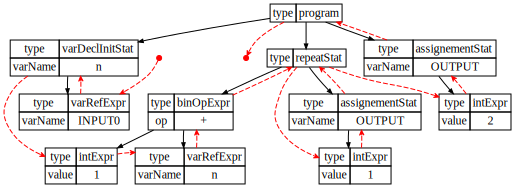

In [29]:
do_thread(ast)
ast.with_threads(THREADS)

## Un esempio completo

In [41]:
source = """
var sel = INPUT0;
var n = INPUT1;

var res;

if sel == 0 then {
    res = 0;
    repeat n times
        res = res + 1;
} else 
    res = 123456;
    
OUTPUT = res;
"""

In [42]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))

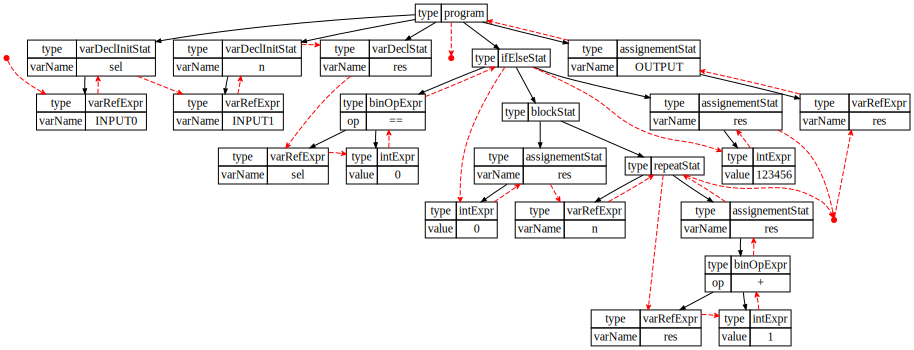

In [43]:
do_thread(ast)
ast.with_threads(THREADS)

# Istruzioni e salti

In [44]:
NODES = list(THREADS.keys())

JUMPS = []
for info in THREADS.values():
    JUMPS.append({k: NODES.index(v) if v is not None else None for k, v in info.items()})

INSTRS = [node.root for node in NODES]

iter2table(zip(INSTRS, JUMPS))

## Un interprete iterativo

In [45]:
def interpreter(indct):

    GLOBAL_MEMORY = indct.copy()
    STACK = Stack()
    IP = 0
    while True:

        instr = INSTRS[IP]
        jump = JUMPS[IP]
        
        if 'next' in jump and jump['next'] == None: break    
        print(IP, instr, jump, STACK)
        
        IP = None
        
        if instr['type'] == 'intExpr':
            STACK.push(instr['value'])

        elif instr['type'] == 'binOpExpr':
            if instr['op'] == '==':
                STACK.push(STACK.pop() == STACK.pop())
            if instr['op'] == '+':
                STACK.push(STACK.pop() + STACK.pop())
                
        elif instr['type'] == 'varRefExpr':
            STACK.push(GLOBAL_MEMORY[instr['varName']])
            
        elif instr['type'] == 'varDeclInitStat':
            GLOBAL_MEMORY[instr['varName']] = STACK.pop()
            
        elif instr['type'] == 'varDeclStat':
            GLOBAL_MEMORY[instr['varName']] = None
            
        elif instr['type'] == 'assignementStat':
            GLOBAL_MEMORY[instr['varName']] = STACK.pop()
            
        elif instr['type'] == 'ifElseStat':
            IP = jump['true'] if STACK.pop() else jump['false']
                        
        elif instr['type'] == 'repeatStat':
            count = STACK.pop()
            if count > 0:
                STACK.push(count - 1)
                IP = jump['repeat']
            else:
                IP = jump['next']

        elif instr['type'] in ('<START>', '<JOIN>'):
            pass
            
        else:
            warn('ignoring: ' + instr['type'])
                
                
        if IP is None: IP = jump['next']
    
    return GLOBAL_MEMORY['OUTPUT']

In [47]:
interpreter({'INPUT0': 1, 'INPUT1': 3})    

0 {'type': '<START>'} {'next': 1} Stack()
1 {'type': 'varRefExpr', 'varName': 'INPUT0'} {'next': 2} Stack()
2 {'type': 'varDeclInitStat', 'varName': 'sel'} {'next': 3} Stack(1 ↔)
3 {'type': 'varRefExpr', 'varName': 'INPUT1'} {'next': 4} Stack()
4 {'type': 'varDeclInitStat', 'varName': 'n'} {'next': 5} Stack(3 ↔)
5 {'type': 'varDeclStat', 'varName': 'res'} {'next': 6} Stack()
6 {'type': 'varRefExpr', 'varName': 'sel'} {'next': 7} Stack()
7 {'type': 'intExpr', 'value': 0} {'next': 8} Stack(1 ↔)
8 {'type': 'binOpExpr', 'op': '=='} {'next': 17} Stack(1, 0 ↔)
17 {'type': 'ifElseStat'} {'true': 9, 'false': 18} Stack(False ↔)
18 {'type': 'intExpr', 'value': 123456} {'next': 19} Stack()
19 {'type': 'assignementStat', 'varName': 'res'} {'next': 20} Stack(123456 ↔)
20 {'type': '<JOIN>'} {'next': 21} Stack()
21 {'type': 'varRefExpr', 'varName': 'res'} {'next': 22} Stack()
22 {'type': 'assignementStat', 'varName': 'OUTPUT'} {'next': 23} Stack(123456 ↔)


123456

# Homework

Fate tutti questo *homework* perché è assolutamente propedeutico ai progetti di **Tipo A**. Chi non è 
in grado di svolgere i seguenti punti lo prenda come indicazione che per poter svolgere un progetto
di Tipo A dovrà impegnarsi molto.

* Per com'è scritta, la procedura `thread` non funziona per gli `if` senza `else`. Sapresete aggiustarla?
* Aggiustate la grammatica aggiungendo le regole per il *ciclo while* secondo la sintassi `while <expr> do 
  <stat>` (dove `while` e `do` sono due nuovi *token* e con `<expr>` e `<stat>` sono indicate le due *rule* 
  già esistenti; verificate che il parsing funzioni con un nuovo pezzo di codice comprendente un ciclo.
* Modificate la generazione dell'AST perché tenga conto del *while*.
* Modificate la funzione `thread` perché tenga conto del *while*.
* Modificate l'interprete perché tenga conto del ciclo *while*.